In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
import torch.nn.functional as F

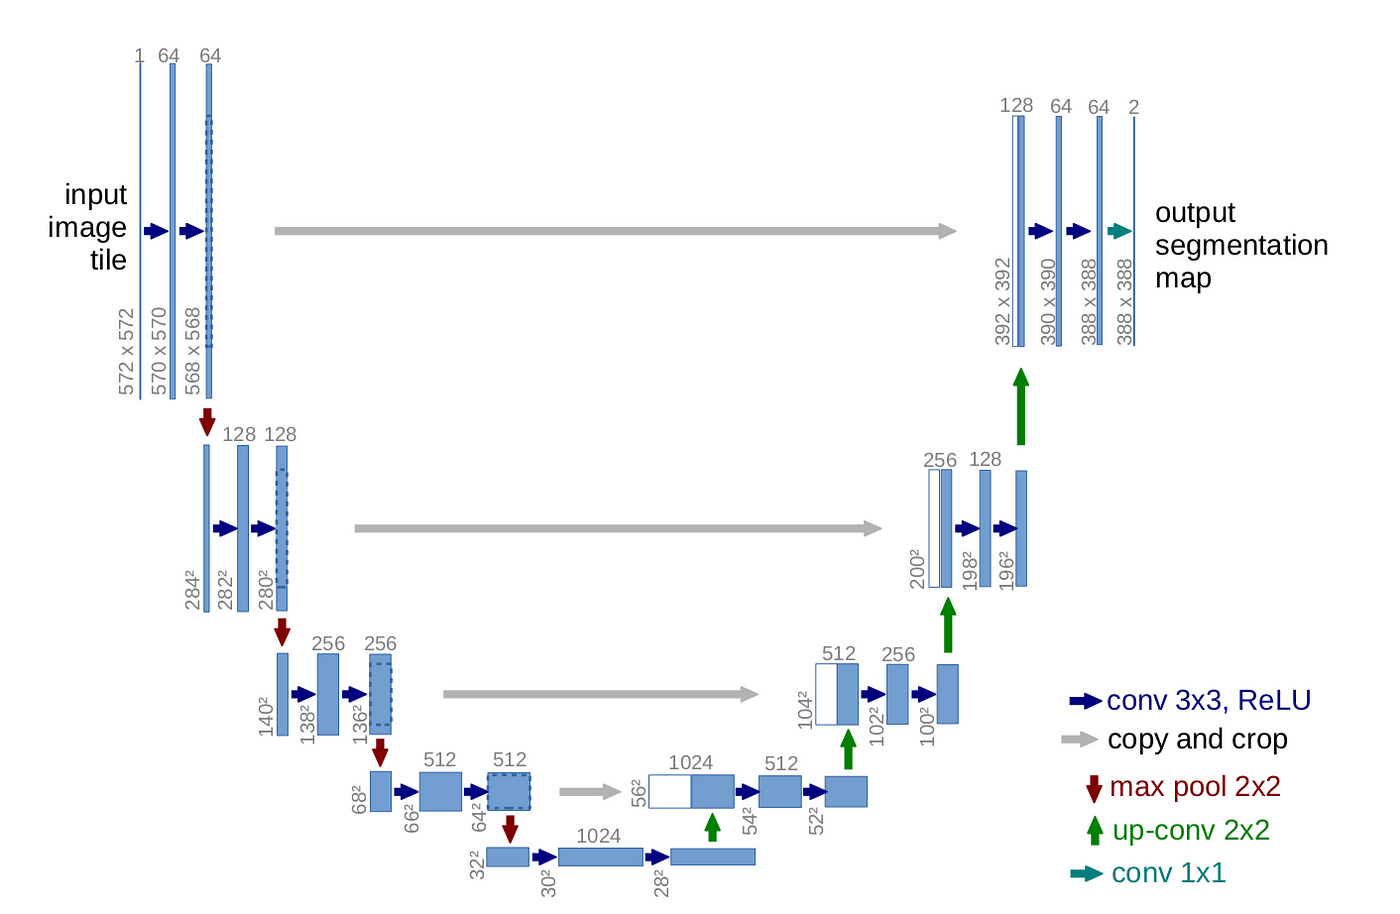

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.conv(x)


In [ ]:
class UNET(nn.Module):
  def __init__(self,in_channels=3,out_channels=1,features=[64,128,256,512]):
    super(UNET,self).__init__()
    self.down = nn.ModuleList()
    self.up = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    for feature in features:
      self.down.append(DoubleConv(in_channels,feature))
      in_channels = feature
    for feature in reversed(features):
      self.up.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
      self.up.append(DoubleConv(feature*2,feature))
    self.bottleneck = DoubleConv(features[-1],features[-1]*2)
    self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)

  def forward(self,x):
    skip_connections = []
    for down in self.down:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)
    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]
    for idx in range(0,len(self.up),2):
      x = self.up[idx](x)
      if x.shape != skip_connections[idx//2].shape:
        x = F.interpolate(x,size=skip_connections[idx//2].shape[2:],mode='bilinear',align_corners=True)
      skip_connection = skip_connections[idx//2]
      concat_skip = torch.cat((skip_connection,x),dim=1)
      x = self.up[idx+1](concat_skip)
    return self.final_conv(x)

In [ ]:
def test():
  x = torch.randn((3,1,161,161))
  model = UNET(in_channels=1,out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape
test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c carvana-image-masking-challenge
!unzip /content/carvana-image-masking-challenge.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 24.4G/24.4G [06:28<00:00, 88.8MB/s]
100% 24.4G/24.4G [06:28<00:00, 67.4MB/s]
Archive:  /content/carvana-image-masking-challenge.zip
  inflating: 29bb3ece3180_11.jpg     
  inflating: metadata.csv.zip        
  inflating: sample_submission.csv.zip  
  inflating: test.zip                
  inflating: test_hq.zip             
  inflating: train.zip               
  inflating: train_hq.zip            
  inflating: train_masks.csv.zip     
  inflating: train_masks.zip         


In [ ]:
!unzip /content/train.zip
!unzip /content/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/f314c61074fa_10.jpg  
  inflating: test/f314c61074fa_11.jpg  
  inflating: test/f314c61074fa_12.jpg  
  inflating: test/f314c61074fa_13.jpg  
  inflating: test/f314c61074fa_14.jpg  
  inflating: test/f314c61074fa_15.jpg  
  inflating: test/f314c61074fa_16.jpg  
  inflating: test/f316c13f8df9_01.jpg  
  inflating: test/f316c13f8df9_02.jpg  
  inflating: test/f316c13f8df9_03.jpg  
  inflating: test/f316c13f8df9_04.jpg  
  inflating: test/f316c13f8df9_05.jpg  
  inflating: test/f316c13f8df9_06.jpg  
  inflating: test/f316c13f8df9_07.jpg  
  inflating: test/f316c13f8df9_08.jpg  
  inflating: test/f316c13f8df9_09.jpg  
  inflating: test/f316c13f8df9_10.jpg  
  inflating: test/f316c13f8df9_11.jpg  
  inflating: test/f316c13f8df9_12.jpg  
  inflating: test/f316c13f8df9_13.jpg  
  inflating: test/f316c13f8df9_14.jpg  
  inflating: test/f316c13f8df9_15.jpg  
  inflating: test/f316c13f8df9_16.jpg  
  inflating: test/f32903f9e03

In [ ]:
!unzip /content/train_masks.zip
!unzip /content/test_hq.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_hq/4157dbb64e2f_02.jpg  
  inflating: test_hq/57c69d33d63c_01.jpg  
  inflating: test_hq/bd10a3a5c94c_08.jpg  
  inflating: test_hq/7700837258ec_07.jpg  
  inflating: test_hq/e7c58b3456a4_11.jpg  
  inflating: test_hq/206b4aeb95a0_16.jpg  
  inflating: test_hq/7955075fb3e8_10.jpg  
  inflating: test_hq/a63f38deb96c_03.jpg  
  inflating: test_hq/cfcfceb2709f_10.jpg  
  inflating: test_hq/3cafa6c6aaa4_07.jpg  
  inflating: test_hq/a891235368c8_09.jpg  
  inflating: test_hq/47b83ac633ca_13.jpg  
  inflating: test_hq/cabb00c66877_01.jpg  
  inflating: test_hq/3a5da2181d16_07.jpg  
  inflating: test_hq/c1bafe0f3fd3_06.jpg  
  inflating: test_hq/b46317657a46_15.jpg  
  inflating: test_hq/c8968181ed46_10.jpg  
  inflating: test_hq/9c08ad02036a_16.jpg  
  inflating: test_hq/7c1af90808f0_14.jpg  
  inflating: test_hq/7fcb858a3c9b_14.jpg  
  inflating: test_hq/355654f67030_03.jpg  
  inflating: test_hq/3d2b9e94edb4_14.jpg  
  i

In [ ]:
class CarvanaDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
  def __len__(self):
    return len(self.images)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
    mask[mask==255.0] = 1.0
    if self.transform is not None:
      augmentations = self.transform(image=image,mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
    return image,mask

In [ ]:
# from utils import (load_checkpoint,save_checkpoint,get_loaders,check_accuracy,save_predictions_as_imgs)

def save_checkpoint(state,filename='my_checkpoint.pth.tar'):
  print("=> Saving Checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])

def check_accuracy(loader,model,device):
  num_correct=0
  num_pixel=0
  dice_score = 0
  model.eval()
  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.unsqueeze(1).to(device)
      preds= torch.sigmoid(model(x))
      preds = (preds>0.5).float()
      num_correct += (preds==y).sum()
      num_pixel += torch.numel(preds)
      dice_score += (2* (preds*y).sum() / (preds+y).sum() + 1e-8)
    print(f"Got {num_correct}/{num_pixel} with acc {(num_correct/num_pixel)*100:.2f}")
    print(f"Dice Score:  {dice_score/len(loader)}")



def save_predictions_as_imgs(loader, model, device,folder="saved_images/"):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
    y = y.cpu().numpy().transpose(0, 2, 3, 1)
    preds = preds.cpu().numpy().transpose(0, 2, 3, 1)
    for i in range(preds.shape[0]):
        # Ensure single channel for saving
        torchvision.utils.save_image(torch.from_numpy(preds[i, :, :, 0]).unsqueeze(0), f"{folder}{idx}_{i}_pred.png")
        # torchvision.utils.save_image(torch.from_numpy(y[i, :, :, 0]).unsqueeze(0), f"{folder}{idx}_{i}_true.png")
  model.train()





In [ ]:
lr = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
num_epochs = 3
num_workers =2
img_height = 160
img_width = 240
pin_memory = True
load_model = False
# train_img_dir = "/content/train"
# train_mask_dir = "/content/train_masks"
# val_img_dir = "/content/test"
# val_mask_dir = "/content/test_masks"

In [ ]:
def train_fn(loader,model,optimizer,loss_fn,scaler):
  loop = tqdm(loader)

  for batch_idx, (data,target) in enumerate(loop):
    data = data.to(device=device)
    target = target.float().to(device=device)

    with torch.cuda.amp.autocast():
      prediction = model(data)
      loss = loss_fn(prediction,target)
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    loop.set_postfix(loss=loss.item())

In [ ]:
# prompt: write transform function for dataset pytorch

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=img_height,width=img_width),
        A.Rotate(limit=35,p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0,0.0,0.0],
            std=[1.0,1.0,1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=img_height,width=img_width),
        A.Normalize(
            mean=[0.0,0.0,0.0],
            std=[1.0,1.0,1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

transform12 = transforms.Compose(
    [
        transforms.Resize((img_height,img_width)),
        transforms.ToTensor(),
    ]
)


In [ ]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),
    common_transform=transforms.Compose([
        transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=transforms.Compose([
        # Color Jitter as data augmentation.
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

In [ ]:
pets_train_orig = OxfordIIITPetsAugmented(root='/content/train', split="trainval", target_types="segmentation",download=True, **transform_dict)
pets_test_orig = OxfordIIITPetsAugmented(root='/content/test', split="test", target_types="segmentation",download=True, **transform_dict)

100%|██████████| 791918971/791918971 [00:30<00:00, 25985577.87it/s]


Extracting /content/train/oxford-iiit-pet/images.tar.gz to /content/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10691395.81it/s]


Extracting /content/train/oxford-iiit-pet/annotations.tar.gz to /content/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:30<00:00, 25846188.22it/s]


Extracting /content/test/oxford-iiit-pet/images.tar.gz to /content/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11312061.65it/s]


Extracting /content/test/oxford-iiit-pet/annotations.tar.gz to /content/test/oxford-iiit-pet


In [ ]:
model = UNET(in_channels=3,out_channels=1).to(device) # out channel = num_classes for multiclass
loss_fn = nn.BCEWithLogitsLoss() # corssentropy loss for multiclass
optimizer = optim.Adam(model.parameters(),lr=lr)
scaler = torch.cuda.amp.GradScaler()
# train_dataset = CarvanaDataset(train_img_dir,train_mask_dir,transform=train_transform)
train_loader = DataLoader(pets_train_orig,batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory,shuffle=True)
# val_dataset = CarvanaDataset(val_img_dir,val_mask_dir,transform=val_transform)
val_loader = DataLoader(pets_test_orig,batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory,shuffle=True)

<ipython-input-11-eaa5b81c95de>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
if load_model:
  load_checkpoint(torch.load('my_checkpoint.pth.tar'),model,optimizer)
for epoch in range(num_epochs):
  model.train()
  train_fn(train_loader,model,optimizer,loss_fn,scaler)
  checkpoint ={'state_dict':model.state_dict(),
                'optimizer':optimizer.state_dict()
  }
  save_checkpoint(checkpoint)
  load_model=True
  check_accuracy(val_loader,model,device=device)
  save_predictions_as_imgs(val_loader,model,device)


<ipython-input-32-954704b4f093>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load('my_checkpoint.pth.tar'),model,optimizer)


=> Loading Checkpoint


  0%|          | 0/230 [00:00<?, ?it/s]<ipython-input-13-4b85dbc16283>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 230/230 [00:55<00:00,  4.11it/s, loss=-2.66]


=> Saving Checkpoint
Got 1413196249/140889600 with acc 1003.05
Dice Score:  0.8386207818984985


100%|██████████| 230/230 [00:59<00:00,  3.88it/s, loss=-2.89]


=> Saving Checkpoint
Got 1426816110/140889600 with acc 1012.72
Dice Score:  0.8427404165267944


100%|██████████| 230/230 [00:59<00:00,  3.85it/s, loss=-4.32]


=> Saving Checkpoint
Got 1436972503/140889600 with acc 1019.93
Dice Score:  0.8517928719520569
